In [17]:
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow.contrib import slim
from tensorflow.keras import layers
import math,random
import collections
import glob, ast
import json

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
restore=False

import numpy as np
import shap

import interpret
run_shap=True


In [2]:
job_max_cardinality = 6.569443203906885
job_min_cardinality = 0.30102999566398

max_cardinality =job_max_cardinality
min_cardinality = job_min_cardinality

with open('encoded_job_onehot.json','r') as f:
    data_dict = json.load(f)
    

In [3]:
train_dict=dict(list(data_dict.items())[:70])
test_dict=dict(list(data_dict.items())[70:])


In [4]:
LOG_DIR="graphs/shaps/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# LOG_DIR ="graphs/shaps/exp1"/

In [5]:
batch_size=32

n1_num = 64
n2_num = 128

table_vlength =n2_num
join_vlength=n2_num
and_vlength=n2_num
normalized_and_vlength=n2_num
or_vlength=n2_num
nested_or_vlength=n2_num

# initializers = tf.contrib.layers.variance_scaling_initializer(
#     factor=2.0,
#     mode='FAN_IN',
#     uniform=False,
#     seed=42,
#     dtype=tf.dtypes.float32
# )

initializers = tf.compat.v1.keras.initializers.he_normal(
    seed=42
)
# initializers = tf.compat.v1.keras.initializers.he_uniform(
#     seed=42
# 
# initializers = tf.compat.v1.initializers.glorot_normal
# initializers = tf.compat.v1.initializers.glorot_uniform

# external_dropout=1 #Percentage of things that will remain (1 means no dropout)... 0.8 would be a good value...
# internal_dropout=1 #Percentage of things that will remain.. 0.65 would be a good value

activation_fn = tf.nn.relu
# activation_fn = tf.nn.leaky_relu
# activation_fn=tf.nn.tanh
# activation_fn=tf.nn.swish

# learning_rate = 0.01
learning_rate = 0.001
# learning_rate = 0.0001

train_optimizer=tf.train.AdamOptimizer(learning_rate)
# train_optimizer=tf.train.RMSPropOptimizer(learning_rate)
# train_optimizer=tf.train.MomentumOptimizer(learning_rate, 0.9, name='Momentum', use_nesterov=False)
# train_optimizer=tf.train.MomentumOptimizer(learning_rate, 0.9, name='Momentum', use_nesterov=True)



In [6]:
#Placeholders for input sets
temp_tables, temp_joins, temp_and, temp_normalized_and = ([] for i in range(4))

#Placeholders for the output of individual input.
tables_output, joins_output, and_output, normalized_and_output = ([] for i in range(4))

cardinalities=[]
target=[] 

def card_est_last_layers(network_type, tables_output, joins_output, and_output, normalized_and_output):
    inp=tf.concat([tables_output, joins_output, and_output, normalized_and_output], axis=1)
    net= tf.nn.dropout(slim.fully_connected(inp, 512, activation_fn,weights_initializer=initializers,weights_regularizer=slim.l2_regularizer(1e-8)),  internal_dropout)
    net= tf.nn.dropout(slim.fully_connected(net, 512, activation_fn,weights_initializer=initializers,weights_regularizer=slim.l2_regularizer(1e-8)), 0.8)
    cardinality = slim.fully_connected(net, 1, activation_fn=tf.nn.sigmoid)
    return network_type(cardinality)

def tables_layers(network_type, tables):
    tables_net= tf.nn.dropout(slim.fully_connected(tables, n1_num, activation_fn,weights_initializer=initializers,weights_regularizer=slim.l2_regularizer(1e-8)),internal_dropout)
    table_vector = tf.nn.dropout(slim.fully_connected(tables_net, table_vlength,  activation_fn),internal_dropout)
    return network_type(table_vector)

def joins_layers(network_type, joins):
    joins_net= tf.nn.dropout(slim.fully_connected(joins, n1_num, activation_fn,weights_initializer=initializers,weights_regularizer=slim.l2_regularizer(1e-8)),internal_dropout)
    join_vector = tf.nn.dropout(slim.fully_connected(joins_net, join_vlength,   activation_fn),internal_dropout)
    return network_type(join_vector)

def and_layers(network_type, ands):
    and_net= tf.nn.dropout(slim.fully_connected(ands, n1_num, activation_fn,weights_initializer=initializers,weights_regularizer=slim.l2_regularizer(1e-8)),internal_dropout)
    and_vector = tf.nn.dropout(slim.fully_connected(and_net, and_vlength,   activation_fn),internal_dropout)
    return network_type(and_vector)

def normalized_and_layers(network_type, normalized_ands):
    normalized_and_net= tf.nn.dropout(slim.fully_connected(normalized_ands, n1_num, activation_fn,weights_initializer=initializers,weights_regularizer=slim.l2_regularizer(1e-8)),internal_dropout)
    normalized_and_vector = tf.nn.dropout(slim.fully_connected(normalized_and_net, normalized_and_vlength,   activation_fn),internal_dropout)
    return network_type(normalized_and_vector)

In [7]:
tf_device='/gpu:0'
print("Device defined")

def _general_network_template(tables_outputs, joins_outputs, and_output, normalized_and_output):
    return card_est_last_layers(collections.namedtuple('DS_network', ['values']), tables_outputs, joins_outputs, and_output, normalized_and_output)

def _tables_network_template(tables):
    return tables_layers(collections.namedtuple('tables_network', ['values']), tables)

def _joins_network_template(joins):
    return joins_layers(collections.namedtuple('joins_network', ['values']), joins)

def _and_network_template(ands):
    return and_layers(collections.namedtuple('and_network', ['values']), ands)

def _normalized_and_network_template(normalized_ands):
    return normalized_and_layers(collections.namedtuple('normalized_and_network', ['values']), normalized_ands)


Device defined


In [8]:
def _build_general_network():
    global cardinalities
    net= tf.make_template('network', _general_network_template)
    cardinalities = net(tables_output, joins_output, and_output, normalized_and_output)
    tf.summary.histogram("predicted cardinalities", cardinalities)

def _build_tables_network():
    global tables_output
    tables_net= tf.make_template('tables_network', _tables_network_template)
    tables_output= tables_net(temp_tables)
    tables_output=tf.reduce_sum(tables_output, 2)[0]

def _build_joins_network():
    global joins_output
    joins_net= tf.make_template('joins_network', _joins_network_template)
    joins_output= joins_net(temp_joins)
    joins_output=tf.reduce_sum(joins_output, 2)[0]
    
def _build_and_network():
    global and_output
    and_net= tf.make_template('and_network', _and_network_template)
    and_output= and_net(temp_and)
    and_output=tf.reduce_sum(and_output, 2)[0]

def _build_normalized_and_network():
    global normalized_and_output
    normalized_and_net= tf.make_template('normalized_and_network', _normalized_and_network_template)
    normalized_and_output= normalized_and_net(temp_normalized_and)
    normalized_and_output=tf.reduce_sum(normalized_and_output, 2)[0]

def _build_train_op():
    loss=tf.keras.losses.MSE(cardinalities[0],tf.reshape(target_ph, (batch_size, 1)))
    print_op=tf.print(tf.reduce_mean(loss))
    #   with tf.variable_scope('Losses'):
    tf.summary.scalar('Loss', tf.reduce_mean(loss))
    with tf.control_dependencies([print_op]):
        a=optimizer.minimize(loss)
        return a

In [9]:
with tf.device(tf_device):  
    cardinalities=tf.placeholder(tf.float32, name='cardinalities_ph')
    target_ph=tf.placeholder(tf.float32, name='target')

    it_ph=tf.placeholder(tf.float32, name='iteration')
    last_layer_outputs=tf.placeholder(tf.float32, (None, 512), name='last_layer_output_ph')

    internal_dropout = tf.placeholder_with_default(1.0, shape=())

    tables_output=tf.placeholder(tf.float32, (None, table_vlength), name='tables_output_ph')
    joins_output=tf.placeholder(tf.float32, (None, join_vlength), name='joins_output_ph')
    and_output=tf.placeholder(tf.float32, (None, and_vlength), name='and_output_ph')
    normalized_and_output=tf.placeholder(tf.float32, (None, normalized_and_vlength), name='normalized_and_output_ph')

    temp_tables=tf.placeholder(tf.float32, (None, None, 21), name='temp_table_ph')
    temp_joins=tf.placeholder(tf.float32, (None, None, 171), name='temp_join_ph') #Note the input size of the temp ones, which should match the size of items in the json
    temp_and=tf.placeholder(tf.float32, (None, None, 391), name='temp_and_ph')
    temp_normalized_and=tf.placeholder(tf.float32, (None, None, 92), name='temp_normalized_and_ph')

    table_net= _build_tables_network()
    join_net= _build_joins_network()
    and_net= _build_and_network()
    normalized_and_net= _build_normalized_and_network()
    net= _build_general_network()
    #   _train_op = _build_train_op()

    loss =tf.keras.losses.MSE(tf.reshape(target_ph, (batch_size, 1)),cardinalities[0])
    train_loss = tf.summary.scalar('Train Loss', tf.reduce_mean(loss))
    loss_info = tf.reduce_mean(loss)

    optimizer=train_optimizer.minimize(loss)

W0528 01:28:26.926853 140190678468416 deprecation.py:506] From <ipython-input-6-ce88031285f1>:18: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
_sess = tf.Session('', config=config)
merged = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(LOG_DIR, _sess.graph)
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()
if not restore:
  _sess.run(init_op)
else:
  saver.restore(_sess, "hyperparameters/model.ckpt")
print("Tensorflow session initalized")

Tensorflow session initalized


In [11]:
def get_inputs(query_batch,data_dict):
    q_names = query_batch
    target = [data_dict[k]['Cardinality'] for k in query_batch]

    all_tables = [data_dict[k]['Tables'] for k in query_batch]
    tables_input = tf.keras.preprocessing.sequence.pad_sequences(all_tables,padding='post',dtype='float64')
    tables_input = np.array(tables_input).tolist()
    # print('Tables:',tables_input[1])

    all_joins = [data_dict[k]['Joins'] for k in query_batch]
    joins_input = tf.keras.preprocessing.sequence.pad_sequences(all_joins,padding='post',dtype='float64')
    joins_input = np.array(joins_input).tolist()
#     print('Joins:',joins_input[1])

    all_ands = [data_dict[k]['Predicate String'] for k in query_batch]
    and_input = tf.keras.preprocessing.sequence.pad_sequences(all_ands,padding='post',dtype='float64')
    and_input = np.array(and_input).tolist()
#     print('Predicate String:',and_input[1][1])

    all_norm_ands = [data_dict[k]['Predicate Numeric'] for k in query_batch]
    normalized_and_input = tf.keras.preprocessing.sequence.pad_sequences(all_norm_ands,padding='post',dtype='float64')
    normalized_and_input = np.array(normalized_and_input).tolist()
    # print('Predicate Numeric:',normalized_and_input[1])
    
    return q_names,target,tables_input,joins_input,and_input,normalized_and_input


In [12]:
total_it = 3001
num_epochs=4

test_batch = np.array(list(test_dict.keys()))
test_q_names,test_target,test_tables_input,test_joins_input,test_and_input,test_normalized_and_input = get_inputs(test_batch,test_dict)
job_results=[]

for num in range(total_it):
    if(num==total_it-1):
        [last_layer] =_sess.run([tf.concat([tables_output, joins_output, and_output, normalized_and_output], axis=1)], feed_dict={it_ph:num, target_ph:test_target, internal_dropout:1.0,
                        temp_tables:np.array(test_tables_input, dtype=np.float32), 
                        temp_joins:np.array(test_joins_input, dtype=np.float32), 
                        temp_and:np.array(test_and_input, dtype=np.float32), 
                        temp_normalized_and:np.array(test_normalized_and_input, dtype=np.float32)
                        })
        [test_result] =_sess.run([cardinalities], feed_dict={it_ph:num, target_ph:test_target, internal_dropout:1.0,
                        temp_tables:np.array(test_tables_input, dtype=np.float32), 
                        temp_joins:np.array(test_joins_input, dtype=np.float32), 
                        temp_and:np.array(test_and_input, dtype=np.float32), 
                        temp_normalized_and:np.array(test_normalized_and_input, dtype=np.float32)
                        })
        for it in range(len(test_result[0])):
            job_results.append(test_result[0][it][0])

    else:        
        train_batch = np.random.choice(np.array(list(train_dict.keys())), batch_size, replace=True)
        train_q_names,train_target,train_tables_input,train_joins_input,train_and_input,train_normalized_and_input = get_inputs(train_batch,train_dict)

        for epoch in range(num_epochs):
            result,summ,train_loss =_sess.run([optimizer,merged,loss_info], feed_dict={it_ph:num, target_ph:train_target,internal_dropout:1.0,
                            temp_tables:np.array(train_tables_input, dtype=np.float32), 
                            temp_joins:np.array(train_joins_input, dtype=np.float32), 
                            temp_and:np.array(train_and_input, dtype=np.float32),
                            temp_normalized_and:np.array(train_normalized_and_input, dtype=np.float32)
                            })
            if(num%10==0):
                summary_writer.add_summary(summ,num)

save_path = saver.save(_sess, "hyperparameters/"+datetime.now().strftime("%Y%m%d-%H%M%S")+"/model.ckpt")

In [13]:
from sklearn.metrics import mean_squared_error
mse_job = mean_squared_error(test_target, job_results)
print(mse_job)

0.024268151451436654


In [14]:
from sklearn.metrics import mean_absolute_error
mae_job = mean_absolute_error(test_target, job_results)
print(mae_job)

0.1298846768338545


In [18]:
if run_shap:
    res=[int(round(10**(x[0]*max_cardinality))) for x in test_result[0]]
    model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
    model_ebm.fit(last_layer, res)

W0528 01:43:32.103962 140190678468416 all.py:340] Passing a numpy array to schema autogen when it should be dataframe.


In [19]:
if run_shap:
    explainer_ebm = shap.AdditiveExplainer(model_ebm, last_layer)
    shap_values_ebm = explainer_ebm.shap_values(last_layer)

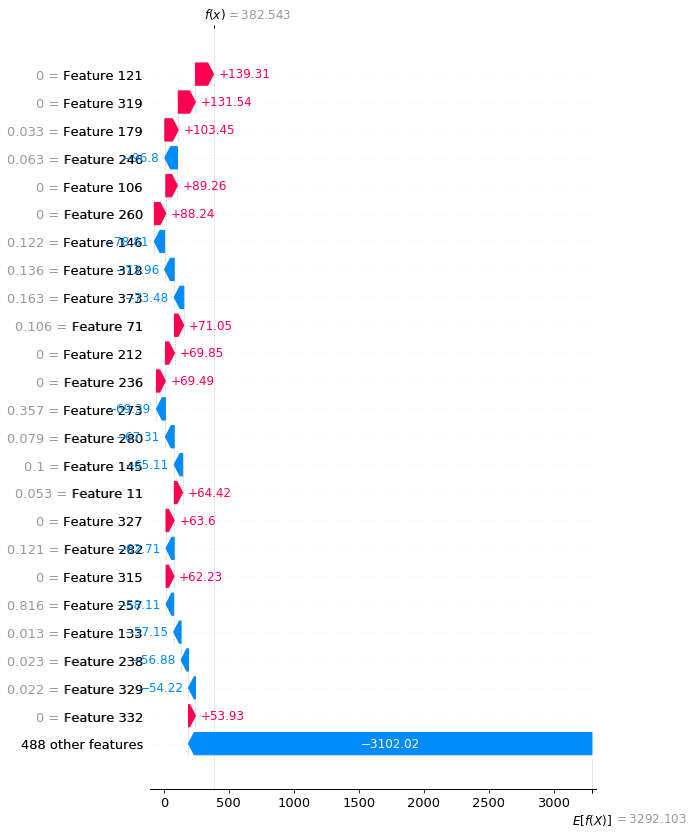

In [20]:
if run_shap:
    instance_number=1
    shap.waterfall_plot(explainer_ebm.expected_value, shap_values_ebm[instance_number], last_layer[instance_number], max_display=25)

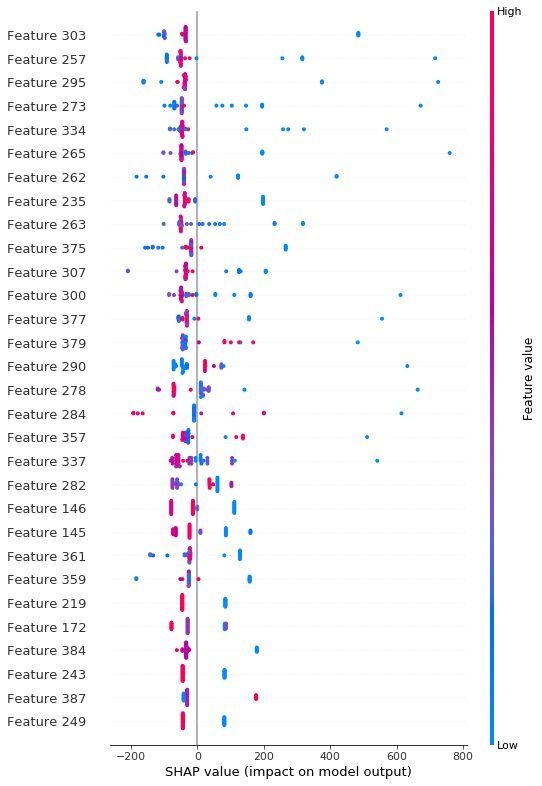

In [23]:
if run_shap:
    shap.summary_plot(shap_values_ebm, last_layer, max_display=30)

In [ ]:
flatui = ["#2ECC71","#34495e"]

q_names = test_q_names
temp_numbers = [re.findall('\d+', query) for query in q_names]
q_template_num = [ item for elem in temp_numbers for item in elem]

In [ ]:
def denormalize_selectivity(cardinality_list):
  denorm_sel=[]
  for val in cardinality_list:
    selectivity_val = (val*(max_cardinality-min_cardinality))+min_cardinality
    final_val = int(round(10**selectivity_val))
    denorm_sel.append(final_val)
  return denorm_sel

denorm_pred_sel = denormalize_selectivity(job_results)
denorm_actual_sel = denormalize_selectivity(test_target)

df_target = pd.DataFrame()
df_target['Query Number'] = test_q_names
df_target['Query Template Number'] = q_template_num
df_target['Cardinality'] = denorm_actual_sel
df_target['Labels'] = 'Target'
df_target.reset_index(drop=True, inplace=True)

df_predicted = pd.DataFrame()
df_predicted['Query Number'] = test_q_names
df_predicted['Query Template Number'] = q_template_num
df_predicted['Cardinality'] = denorm_pred_sel
df_predicted['Labels'] = 'Predicted'
df_predicted.reset_index(drop=True, inplace=True)

df = df_target.append(df_predicted,ignore_index=True)


In [ ]:
df_log = df
df_log['Cardinality'] = np.log(df['Cardinality'])

plt.figure(figsize=(29, 9))
sns.barplot(x="Query Number", y="Cardinality", hue="Labels", data=df_log, palette=flatui)
plt.ylabel("Cardinalities", size=14)
plt.xlabel("Query Numbers", size=14)
plt.xticks(rotation=90) 
plt.title("Target vs Predicted Cardinality", size=18)
plt.savefig("plots/log/embeddings/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"log_scale_all_prediction_bars.png")

query_templates=df_log['Query Template Number'].unique().tolist()
for template in query_templates:
    data_to_plot = df_log.loc[df_log['Query Template Number']==template]
    plt.figure(figsize=(8, 5))
    sns.barplot(x="Query Number", y="Cardinality", hue="Labels", data=data_to_plot, palette=flatui)
    plt.ylabel("Cardinalities", size=11)
    plt.xlabel("Query Numbers", size=11)
    plt.title("Actual vs Predicted Cardinality", size=11)
    plt.savefig("plots/log/embeddings/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+template+"_logscale_prediction_bars.png")

In [ ]:
# query_templates=df['Query Template Number'].unique().tolist()
# # print(len(query_templates))
# for template in query_templates:
#     data_to_plot = df.loc[df['Query Template Number']==template]
#     plt.figure(figsize=(8, 5))
#     sns.barplot(x="Query Number", y="Cardinality", hue="Labels", data=data_to_plot, palette=flatui)
#     plt.ylabel("Cardinalities", size=11)
#     plt.xlabel("Query Numbers", size=11)
#     plt.title("Actual vs Predicted Cardinality", size=11)
#     plt.savefig("plots/linear/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+template+"_linearscale_prediction_bars.png")

In [ ]:
sns.set()
palette='GnBu'

vars = tf.trainable_variables()
# print(vars)
vars_vals = _sess.run(vars)
np.set_printoptions(threshold=np.inf)

plt_size_layer1=(35,15)
plt_size_layer2 = (45,35)
for var, val in zip(vars, vars_vals):
    
    if var.name=="tables_network/fully_connected/weights:0":
        print("table input weights at Layer 1:")
        plt.figure(figsize=plt_size_layer1)
        ax = sns.heatmap(val,cmap=palette,robust=True,annot=True, fmt=".1f",square=False)
        ax.set_ylabel('Table Sets Input')
        ax.set_xlabel('Units of Hidden Layer 1')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"annoted_heatmap_tables_layer1.png")
        plt.show()
    if var.name=="tables_network/fully_connected/weights:0":
        print("table input weights at Layer 1:")
        plt.figure(figsize=plt_size_layer1)
        ax = sns.heatmap(val,cmap=palette,robust=True,annot=False, fmt=".1f",square=False)
        ax.set_ylabel('Table Sets Input')
        ax.set_xlabel('Units of Hidden Layer 1')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"heatmap_tables_layer1.png")
        plt.show()
    if var.name=="tables_network/fully_connected_1/weights:0":
        print("table input weights at Layer 2:")
        plt.figure(figsize=plt_size_layer2)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_ylabel('Table Sets Input')
        ax.set_xlabel('Units of Hidden Layer 2')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"heatmap_tables_layer2.png")
        plt.show()
        
    if var.name=="joins_network/fully_connected/weights:0":
        print("joins input weights:")
        plt.figure(figsize=plt_size_layer1)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_ylabel('Join Sets Input')
        ax.set_xlabel('Units of Hidden Layer 1')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"heatmap_joins_layer1.png")
        plt.show()
    if var.name=="joins_network/fully_connected_1/weights:0":
        print("joins input weights:")
        plt.figure(figsize=plt_size_layer2)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_ylabel('Join Sets Input')
        ax.set_xlabel('Units of Hidden Layer 2')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"heatmap_joins_layer2.png")
        plt.show()
         
    if var.name=="and_network/fully_connected/weights:0":
        print("and input weights:")
        plt.figure(figsize=plt_size_layer2)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_ylabel('Predicate String Sets Input')
        ax.set_xlabel('Units of Hidden Layer 1')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"heatmap_pred_str_layer1.png")
        plt.show()      
    if var.name=="and_network/fully_connected_1/weights:0":
        print("and input weights:")
        plt.figure(figsize=plt_size_layer2)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_ylabel('Predicate String Sets Input')
        ax.set_xlabel('Units of Hidden Layer 2')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"heatmap_pred_str_layer2.png")
        plt.show()
               
    if var.name=="normalized_and_network/fully_connected/weights:0":
        print("normalized and input weights:")
        plt.figure(figsize=plt_size_layer1)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_ylabel('Predicate Numeric Sets Input')
        ax.set_xlabel('Units of Hidden Layer 1')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"heatmap_pred_num_layer1.png")
        plt.show()
    if var.name=="normalized_and_network/fully_connected_1/weights:0":
        print("normalized and input weights:")
        plt.figure(figsize=plt_size_layer2)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_ylabel('Predicate Numeric Sets Input')
        ax.set_xlabel('Units of Hidden Layer 2')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"heatmap_pred_num_layer2.png")
        plt.show()
       
    if var.name=="network/fully_connected/weights:0":
        print("overall concat weights:")
        plt.figure(figsize=plt_size_layer2)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_xlabel('Units of Hidden Layer 3')
        ax.set_ylabel('Concatenated Inputs at Layer 3')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"concatenated_layer3.png")
        plt.show()
    if var.name=="network/fully_connected_1/weights:0":
        print("overall concat weights:")
        plt.figure(figsize=plt_size_layer2)
        ax = sns.heatmap(val,cmap=palette,robust=True,square=False)
        ax.set_ylabel('Concatenated Inputs at Layer 4')
        ax.set_xlabel('Units of Hidden Layer 4')
        ax.figure.savefig("plots/heatmaps/"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"concatenated_layer4.png")
        plt.show()
